In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)


• Using TensorFlow Version: 2.12.0
• Using TensorFlow Hub Version:  0.13.0


## Image Flow

In [28]:
data_dir = 'Data'

datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1) # set validation split

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=42) # set as training data

validation_generator = datagen.flow_from_directory(
    data_dir, # same directory as training data
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=42) # set as validation data

num_classes = len(np.unique(train_generator.labels))

Found 25007 images belonging to 14 classes.
Found 2773 images belonging to 14 classes.


In [29]:
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)

Classes: ['Arctic_Fox', 'Butterfly', 'Cat', 'Cheetah', 'Chicken', 'Chimpanzee', 'Cow', 'Dog', 'Elephant', 'Hamster', 'Horse', 'Sheep', 'Spider', 'Squirrel']


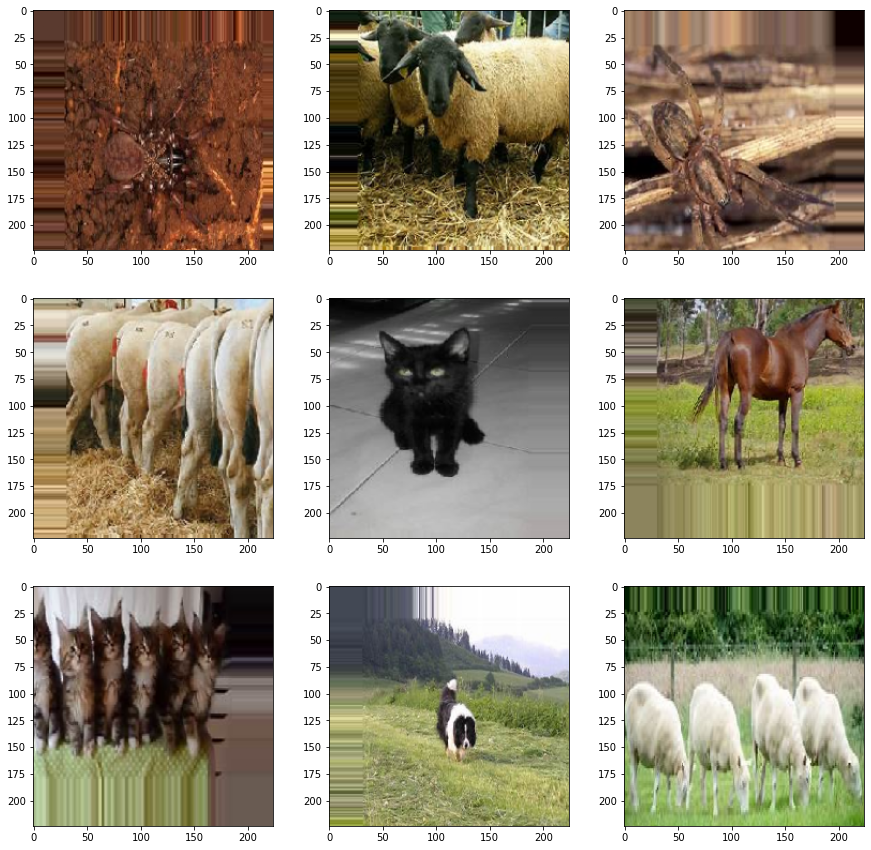

In [30]:
#Displaying train image sample
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(330 + 1 + i)
    img, label = train_generator.next()
    plt.imshow(img[0])
plt.show()

## Model

### Select the Hub/TF2 Module to Use

In [31]:
module_selection = ("mobilenet_v2", 224, 1280)

handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5"
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

Using https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5 with input size (224, 224) and output dimension 1280


### Define Model

In [39]:
do_fine_tuning = True

In [40]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,), 
                                   output_shape=[FV_SIZE],
                                   trainable=do_fine_tuning)

In [41]:
print("Building model with", MODULE_HANDLE)

model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/classification/5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 1001)              2555993   
                                                                 
 dropout_3 (Dropout)         (None, 1001)              0         
                                                                 
 dense_5 (Dense)             (None, 14)                14028     
                                                                 
Total params: 2,570,021
Trainable params: 2,557,909
Non-trainable params: 12,112
_________________________________________________________________


In [43]:
if do_fine_tuning:
    feature_extractor.trainable = True    
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.002, momentum=0.9),
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
else:
    feature_extractor.trainable = False
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [44]:
#define custom callbacks
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='model_14class_v3.h5',
        monitor='val_loss', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,verbose=1)
]

In [45]:
history = model.fit(train_generator,
                 validation_data=validation_generator,
                 epochs=50,
                 batch_size = 32,
                 callbacks = [callbacks_list])

Epoch 1/50
782/782 [==============================] - ETA: 0s - loss: 1.0311 - accuracy: 0.8315
Epoch 1: val_loss improved from inf to 0.68434, saving model to model_14class_v3.h5
782/782 [==============================] - 1206s 2s/step - loss: 1.0311 - accuracy: 0.8315 - val_loss: 0.6843 - val_accuracy: 0.9268
Epoch 2/50
782/782 [==============================] - ETA: 0s - loss: 0.7388 - accuracy: 0.9081
Epoch 2: val_loss improved from 0.68434 to 0.62228, saving model to model_14class_v3.h5
782/782 [==============================] - 1062s 1s/step - loss: 0.7388 - accuracy: 0.9081 - val_loss: 0.6223 - val_accuracy: 0.9416
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.9235
Epoch 3: val_loss improved from 0.62228 to 0.62212, saving model to model_14class_v3.h5
782/782 [==============================] - 1026s 1s/step - loss: 0.6830 - accuracy: 0.9235 - val_loss: 0.6221 - val_accuracy: 0.9484
Epoch 4/50
782/782 [==============================] -

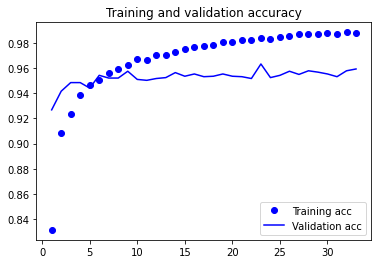

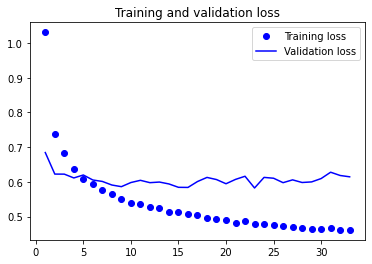

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [2]:
# Load the best saved model
model = tf.keras.models.load_model(
       ('model_14class_v3.h5'),
       custom_objects={'KerasLayer':hub.KerasLayer}
)

In [55]:
score = model.evaluate_generator(train_generator)
print('train loss:', score[0])
print('train accuracy:', score[1])

C:\Users\alvan\AppData\Local\Temp\ipykernel_18604\3780800266.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(train_generator)


train loss: 0.44401901960372925
train accuracy: 0.9962810277938843


In [57]:
score = model.evaluate_generator(validation_generator)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

C:\Users\alvan\AppData\Local\Temp\ipykernel_18604\351518639.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  score = model.evaluate_generator(validation_generator)


Val loss: 0.5993010401725769
Val accuracy: 0.9549224376678467


## Export Model

In [ ]:
# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TensorFlow Lite model to a file
with open("model_14class_v3.tflite", "wb") as f:
    f.write(tflite_model)